<a href="https://colab.research.google.com/github/DJCordhose/ux-by-tfjs/blob/master/notebooks/click-sequence-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training on Sequences of Clicks on the Server

In [0]:
# for colab
!pip install -q tf-nightly-gpu-2.0-preview

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190628


In [3]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print("This works: {}".format(hello))

This works: b'Hello TF!'


In [4]:
# this should return True even on Colab
tf.test.is_gpu_available()

True

In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
tf.executing_eagerly()

True

## load data

In [17]:
import pandas as pd
print(pd.__version__)

0.24.2


In [18]:
import numpy as np
print(np.__version__)

1.16.4


In [0]:
# local
# URL = '../data/click-sequence.json'

# remote
URL = 'https://raw.githubusercontent.com/DJCordhose/ux-by-tfjs/master//data/click-sequence.json'


df = pd.read_json(URL, typ='series')

In [9]:
len(df)

26

In [15]:
df.head()

0                                                   []
1                   [train-model, save-model-to-local]
2                      [load-local-model, train-model]
3    [load-local-model, train-model, toggle-visor, ...
4    [train-model, show-eval, train-model, save-mod...
dtype: object

In [24]:
type(df[0])

list

In [23]:
df[0], df[1]

([], ['train-model', 'save-model-to-local'])

In [27]:
all_buttons = set()
for seq in df:
  for button in seq:
    all_buttons.add(button)

all_buttons.add('<START>')
all_buttons.add('<EMPTY>')

all_buttons = list(all_buttons)

print(all_buttons)

['show-eval', '<START>', 'upload-model', 'train-model', '<EMPTY>', 'reset-data', 'show-model', 'reset-model', 'toggle-prediction', 'load-local-model', 'save-model-to-local', 'toggle-visor', 'download-model']


In [28]:
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, LabelEncoder
encoder = LabelEncoder()
encoder.fit(all_buttons)
encoder.classes_

array(['<EMPTY>', '<START>', 'download-model', 'load-local-model',
       'reset-data', 'reset-model', 'save-model-to-local', 'show-eval',
       'show-model', 'toggle-prediction', 'toggle-visor', 'train-model',
       'upload-model'], dtype='<U19')

In [31]:
transfomed_labels = [encoder.transform(seq) for seq in df if len(seq) != 0]
print(transfomed_labels)

[array([11,  6]), array([ 3, 11]), array([ 3, 11, 10, 10, 11,  5, 11]), array([11,  7, 11,  6]), array([ 3, 11,  7,  6,  2, 10,  9]), array([11,  8, 10,  7, 10, 10,  6,  9]), array([11, 10,  6, 10,  7,  4, 11, 10,  6,  7,  7,  7]), array([11, 11,  6,  7, 10,  9,  6,  2]), array([12, 12, 12, 12,  9]), array([ 4, 11,  9,  7,  9,  9,  9, 10,  9,  9,  5, 11, 10,  6, 11,  6,  7,
        7,  9, 10,  9,  5, 11, 10,  6,  7,  7,  9,  9]), array([11,  6, 10,  2,  9, 12, 12, 10,  7,  7]), array([12, 12,  9,  4,  9]), array([11,  9, 10]), array([11]), array([11,  7,  5, 11, 10, 10, 10,  7,  7, 11,  5, 11,  6,  7,  7,  4,  5,
       11, 10,  7,  7, 10,  5, 11, 10,  6, 10,  9,  9, 11, 10, 10,  9,  9,
       11, 10,  6,  7,  7, 10,  9]), array([11]), array([11]), array([11,  3,  9, 10,  9]), array([ 9,  3,  3,  9,  9,  9, 11, 10, 10,  7,  7,  9, 10, 11]), array([11, 10])]


## pre-process data into chunks

In [123]:
empty = encoder.transform(['<EMPTY>'])
start = encoder.transform(['<START>'])
chunk_size = 5

array([ 4, 11,  9,  7,  9,  9,  9, 10,  9,  9,  5, 11, 10,  6, 11,  6,  7,
        7,  9, 10,  9,  5, 11, 10,  6,  7,  7,  9,  9])

In [0]:
# [ 1, 11,  7, 11,  6] => [[[0, 0, 0, 0, 1], 11], [[0, 0, 0, 1, 11], 7], [[0, 0, 1, 11, 7], 11], [[0, 1, 11, 7, 11], 6]]

def create_sequences(seq, chunk_size, empty, start):
  # all sequences implicitly start
  seq = np.append(start, seq)
  # if sequence is too short, we pad it to minimum size at the beginning
  seq = np.append(np.full(chunk_size - 1, empty), seq)
  
  seqs = np.array([])
  for index in range(chunk_size, len(seq)):
    y = seq[index]
    x = seq[index-chunk_size : index]
    seqs = np.append(seqs, [x, y])
  return seqs

In [276]:

# seq = transfomed_labels[0]
# seq = transfomed_labels[9]
seq = transfomed_labels[3]
seq

array([11,  7, 11,  6])

In [277]:
create_sequences(seq, chunk_size, empty, start)

array([array([0, 0, 0, 0, 1]), 11, array([ 0,  0,  0,  1, 11]), 7,
       array([ 0,  0,  1, 11,  7]), 11, array([ 0,  1, 11,  7, 11]), 6],
      dtype=object)

In [330]:
seqs = np.array([])
for seq in transfomed_labels:
  seqs = np.append(seqs, create_sequences(seq, chunk_size, empty, start))
seqs = seqs.reshape(-1, 2)
seqs.shape

(167, 2)

In [334]:
X = seqs[:, 0]
# X = X.reshape(-1, chunk_size)
X = np.vstack(X)
X.shape

(167, 5)

In [335]:
y = seqs[:, 1]
y

array([11, 6, 3, 11, 3, 11, 10, 10, 11, 5, 11, 11, 7, 11, 6, 3, 11, 7, 6,
       2, 10, 9, 11, 8, 10, 7, 10, 10, 6, 9, 11, 10, 6, 10, 7, 4, 11, 10,
       6, 7, 7, 7, 11, 11, 6, 7, 10, 9, 6, 2, 12, 12, 12, 12, 9, 4, 11, 9,
       7, 9, 9, 9, 10, 9, 9, 5, 11, 10, 6, 11, 6, 7, 7, 9, 10, 9, 5, 11,
       10, 6, 7, 7, 9, 9, 11, 6, 10, 2, 9, 12, 12, 10, 7, 7, 12, 12, 9, 4,
       9, 11, 9, 10, 11, 11, 7, 5, 11, 10, 10, 10, 7, 7, 11, 5, 11, 6, 7,
       7, 4, 5, 11, 10, 7, 7, 10, 5, 11, 10, 6, 10, 9, 9, 11, 10, 10, 9,
       9, 11, 10, 6, 7, 7, 10, 9, 11, 11, 11, 3, 9, 10, 9, 9, 3, 3, 9, 9,
       9, 11, 10, 10, 7, 7, 9, 10, 11, 11, 10], dtype=object)

## Training

In [336]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Sequential, Model

embedding_dim = 2
n_buttons = len(encoder.classes_) + 1

model = Sequential()
model.add(Embedding(name='embedding',
                    input_dim=n_buttons, 
                    output_dim=embedding_dim, 
#                     input_length=1))
                    input_length=chunk_size))

model.add(SimpleRNN(units=50, activation='relu', name="RNN"))

model.add(Dense(units=n_buttons, name='softmax', activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5, 2)              28        
_________________________________________________________________
RNN (SimpleRNN)              (None, 50)                2650      
_________________________________________________________________
softmax (Dense)              (None, 14)                714       
Total params: 3,392
Trainable params: 3,392
Non-trainable params: 0
_________________________________________________________________


In [339]:
%%time

EPOCHS = 1000
BATCH_SIZE = 50

history = model.fit(X, y, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, verbose=0, validation_split=0.2)

CPU times: user 40.2 s, sys: 3.98 s, total: 44.2 s
Wall time: 27 s


In [341]:
loss, accuracy = model.evaluate(X, y, batch_size=BATCH_SIZE)
accuracy

167/167 [==============================] - 0s 1ms/sample - loss: 2.2849 - accuracy: 0.7305


0.7305389

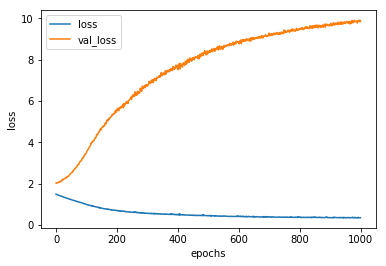

In [342]:
%matplotlib inline

import matplotlib.pyplot as plt

# plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['loss', 'val_loss'])

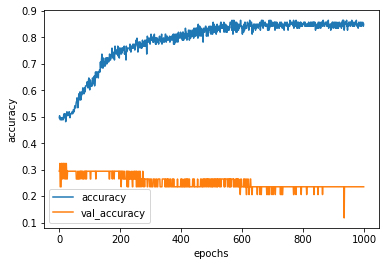

In [343]:
plt.ylabel('accuracy')
plt.xlabel('epochs')

# TF 2.0
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])

plt.legend(['accuracy', 'val_accuracy'])

In [344]:
model.predict([[X[0]]])

array([[1.0893974e-13, 2.8058414e-14, 6.7702580e-23, 1.4286403e-01,
        5.9293248e-02, 7.2682456e-09, 3.9855582e-03, 1.6718288e-05,
        2.7967630e-05, 4.3888539e-03, 1.3565112e-06, 6.7102194e-01,
        1.1840034e-01, 1.3259931e-13]], dtype=float32)

In [345]:
model.predict([[X[0]]]).argmax()

11

In [346]:
y[0]

11

In [352]:
y_pred = model.predict([X]).argmax(axis=1)
y_pred

array([11,  7, 11, 11, 11, 11, 10, 10, 11,  5, 11, 11,  7,  6,  6, 11, 11,
       10,  6,  2, 10,  9, 11,  7, 10,  7, 10, 10,  6,  9, 11,  7,  6, 10,
        7,  4, 11, 10,  6,  7,  7,  7, 11,  7, 11,  7, 10,  9,  6,  2, 11,
       12, 12, 12,  9, 11, 11,  9,  7,  9,  9,  9, 10,  9,  9,  5, 11, 10,
        6,  7,  6,  7,  7,  9, 10,  9,  5, 11, 10,  6,  7,  7,  7,  9, 11,
        7, 10,  2,  9, 12, 12, 10,  7,  7, 11, 12, 12,  4,  9, 11,  7, 10,
       11, 11,  7,  6, 11, 10, 10, 10,  7,  7, 11,  5, 11,  6,  7,  7,  4,
        5, 11, 10,  7,  7, 10,  5, 11, 10,  6, 10,  9,  9, 11,  9,  9,  6,
        7,  7,  5,  9,  6,  7,  7,  9, 11, 11, 11,  7, 11,  7, 10, 11,  7,
       11, 10, 10,  7,  9, 10,  9,  6,  7,  7,  5,  9, 11,  7])

In [354]:
y

array([11, 6, 3, 11, 3, 11, 10, 10, 11, 5, 11, 11, 7, 11, 6, 3, 11, 7, 6,
       2, 10, 9, 11, 8, 10, 7, 10, 10, 6, 9, 11, 10, 6, 10, 7, 4, 11, 10,
       6, 7, 7, 7, 11, 11, 6, 7, 10, 9, 6, 2, 12, 12, 12, 12, 9, 4, 11, 9,
       7, 9, 9, 9, 10, 9, 9, 5, 11, 10, 6, 11, 6, 7, 7, 9, 10, 9, 5, 11,
       10, 6, 7, 7, 9, 9, 11, 6, 10, 2, 9, 12, 12, 10, 7, 7, 12, 12, 9, 4,
       9, 11, 9, 10, 11, 11, 7, 5, 11, 10, 10, 10, 7, 7, 11, 5, 11, 6, 7,
       7, 4, 5, 11, 10, 7, 7, 10, 5, 11, 10, 6, 10, 9, 9, 11, 10, 10, 9,
       9, 11, 10, 6, 7, 7, 10, 9, 11, 11, 11, 3, 9, 10, 9, 9, 3, 3, 9, 9,
       9, 11, 10, 10, 7, 7, 9, 10, 11, 11, 10], dtype=object)

In [358]:
# TF 2.0
cm = tf.math.confusion_matrix(labels=tf.constant(y, dtype=tf.int64), predictions=tf.constant(y_pred, dtype=tf.int64))
cm

<tf.Tensor: id=38333, shape=(13, 13), dtype=int32, numpy=
array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  4,  0],
       [ 0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  6,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 11,  2,  0,  1,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  2, 23,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  5,  0, 18,  3,  2,  1],
       [ 0,  0,  0,  0,  0,  2,  0,  4,  0,  3, 24,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  3,  0,  2,  0, 28,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  6]], dtype=int32)>

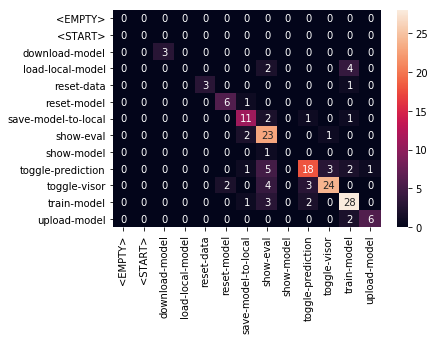

In [361]:
import seaborn as sns

classes = encoder.classes_

sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)

## Convert Model into tfjs format

In [0]:
model.save('ux.hd5')

In [0]:
!ls -l

total 72
drwxr-xr-x 1 root root  4096 Apr  4 20:20 sample_data
-rw-r--r-- 1 root root 67760 Apr 12 08:33 ux.hd5


In [0]:
!pip install -q tensorflowjs

    100% |████████████████████████████████| 81kB 12.6MB/s 
    100% |████████████████████████████████| 13.9MB 1.8MB/s 
    100% |████████████████████████████████| 86.2MB 251kB/s 
    100% |████████████████████████████████| 3.0MB 7.1MB/s 
    100% |████████████████████████████████| 61kB 21.0MB/s 
    100% |████████████████████████████████| 358kB 19.2MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


In [0]:
!tensorflowjs_converter --input_format keras ux.hd5 tfjs

In [0]:
!ls -l tfjs

total 20
-rw-r--r-- 1 root root 12612 Apr 12 08:35 group1-shard1of1.bin
-rw-r--r-- 1 root root  3313 Apr 12 08:35 model.json


Download using _Files_ menu on the left